# Notebook to Generate All Plots in the Paper

### Preliminaries

In [1]:
from eval_model_helpers import *
sys.path.append(os.path.join('..'))
from models.func_to_func2d_invasive import FNO2d
from util.utilities_module import *
from gen_GRF import *
import torch
import matplotlib.pyplot as plt
import matplotlib
import numpy as np


In [9]:

# Plot defaults
# Set font default
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = ['Dejavu Serif'] #'STIXGeneral'
matplotlib.rcParams['mathtext.fontset'] = 'custom'
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00',
                    '#000000']
matplotlib.rcParams['mathtext.rm'] = 'stix'
matplotlib.rcParams['mathtext.it'] = 'stix'
matplotlib.rcParams['mathtext.bf'] = 'stix'


matplotlib.rcParams["axes.formatter.limits"] = (-99, 99) #makes scientific notation threshold high
plt.rcParams['font.family'] = 'Dejavu Serif'
plt.rcParams['font.serif'] = ['Times'] #['Times New Roman']  # 'DejaVu Serif' 'serif' 'Times

tickfontsize = 32
fontsize = 32
linewidth = 4
markersize = 15

SMALL_SIZE = tickfontsize
MEDIUM_SIZE = tickfontsize
BIGGER_SIZE = fontsize

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

shapes = ['o','s','^','D','*', 'x', 'P', 'h', 'v', '<', '>', 'X', 'd', 'p', '|', '_', '.', ',']



In [3]:
# Generate data (GRF inputs)
s_vals = [0.5, 1.0, 1.5, 2.0]
sizes = [64, 128, 256, 512, 1024]


## Trained Model for Smooth Inputs with X-Y Grid and Periodic Grid

#### For a randomly generated FNO with five layers, define a function to output the function values at each layer

In [16]:
# Load config file
config_name = 'smooth_x_y_grid'
model_name = config_name
# print CUDA available
print(torch.cuda.is_available())
config_path = '../models/trained_models/' + config_name + '_info.yaml'
with open(config_path, 'r') as file:
    config = yaml.load(file, Loader=yaml.FullLoader)

# Load input and output data
input_data = torch.load('../data/smooth_training_data/A_to_chi1_tiny_input_data.pt')
output_data = torch.load('../data/smooth_training_data/A_to_chi1_tiny_output_data.pt')

model_name = config['model_name']

False


In [15]:
def get_err_norms(s,model_name, sizes = [32, 64, 128, 256],dup_input = True):
    model_sample = 0
    # model_name = 'initial_model_K_12_0_all1'
    model_info_path = '../models/trained_models/' + model_name + '_info.yaml'
    model_path = '../models/trained_models/' + model_name + '.pt'

    samp_count_model = 1
    samp_count_input = 5
    true_size = sizes[-1]
  
    # Load model
    model = load_model(model_info_path, model_path,s_outputspace = (true_size,true_size))
    model_info = load_model_info(model_info_path)
    n_layers = model_info['n_layers'] -1

    true_norms = torch.zeros(n_layers, samp_count_input)
    all_err = torch.zeros(len(sizes)-1,n_layers, samp_count_model, samp_count_input)

    for input_i in range(samp_count_input):
        true_input_path = '../data/GRF_s' + str(s) +'_GRF_size_' + str(true_size) + '_' + str(input_i)+ '.pkl'
        input_true = load_data(true_input_path)
        input_true = input_true.unsqueeze(0).unsqueeze(0)
        if dup_input:
            # duplicate along axis 1
            input_true = input_true.repeat(1,3,1,1)
            # set middle channel to 0
            input_true[:,1] = 0
        else:
            pass

        layers_true = get_layer_output(model,input_true)

        for size_i, size in enumerate(sizes[:-1]):
            disc_input_path = '../data/GRF_s' +str(s) + f'_GRF_size_{size}_'+ str(input_i)+'.pkl'
            input_disc = load_data(disc_input_path)
            input_disc = input_disc.unsqueeze(0).unsqueeze(0)
            if dup_input:
                input_disc = input_disc.repeat(1,3,1,1)
                input_disc[:,1] = 0
            else:
                pass
            layers_disc = get_layer_output(model,input_disc)
            for layer in range(n_layers):
                err = torch.norm(layers_disc[layer] - layers_true[layer])
                all_err[size_i,layer, 0, input_i] = err

                true_norms[layer, input_i] = torch.norm(layers_true[layer])

    all_err = all_err.detach().numpy()
    true_norms = true_norms.detach().numpy()
    all_err = all_err.reshape(len(sizes)-1,n_layers,samp_count_model*samp_count_input)

    return all_err, true_norms

def eval_model(model_name, exp,index_count = 1):
    '''
    Experiment options affect data. Options are: 'xy', 'periodic', 'grad'
    '''
    model_info_path = '../models/trained_models/' + model_name + '_info.yaml'
    model_path = '../models/trained_models/' + model_name + '.pt'
    model = load_model(model_info_path, model_path,s_outputspace = (128,128))
    model_info = load_model_info(model_info_path)

    if exp == 'xy' or exp == 'periodic':
        input_data = torch.load('../data/smooth_training_data/A_to_chi1_tiny_input_data.pt')
        output_data = torch.load('../data/smooth_training_data/A_to_chi1_tiny_output_data.pt')
    elif exp == 'grad':
        input_data = torch.load('../data/grad_training_data/input_data_grad_tiny.pt')
        output_data = torch.load('../data/grad_training_data/output_data_grad_tiny.pt')

    input_samples = input_data[:index_count]
    output_samples = output_data[:index_count]
    preds = model(input_samples)

    return input_samples, output_samples, preds

#### Plot input and output predicted vs true for the Smooth Data x-y grid Model

Mean Relative Error:  0.005825319327414036


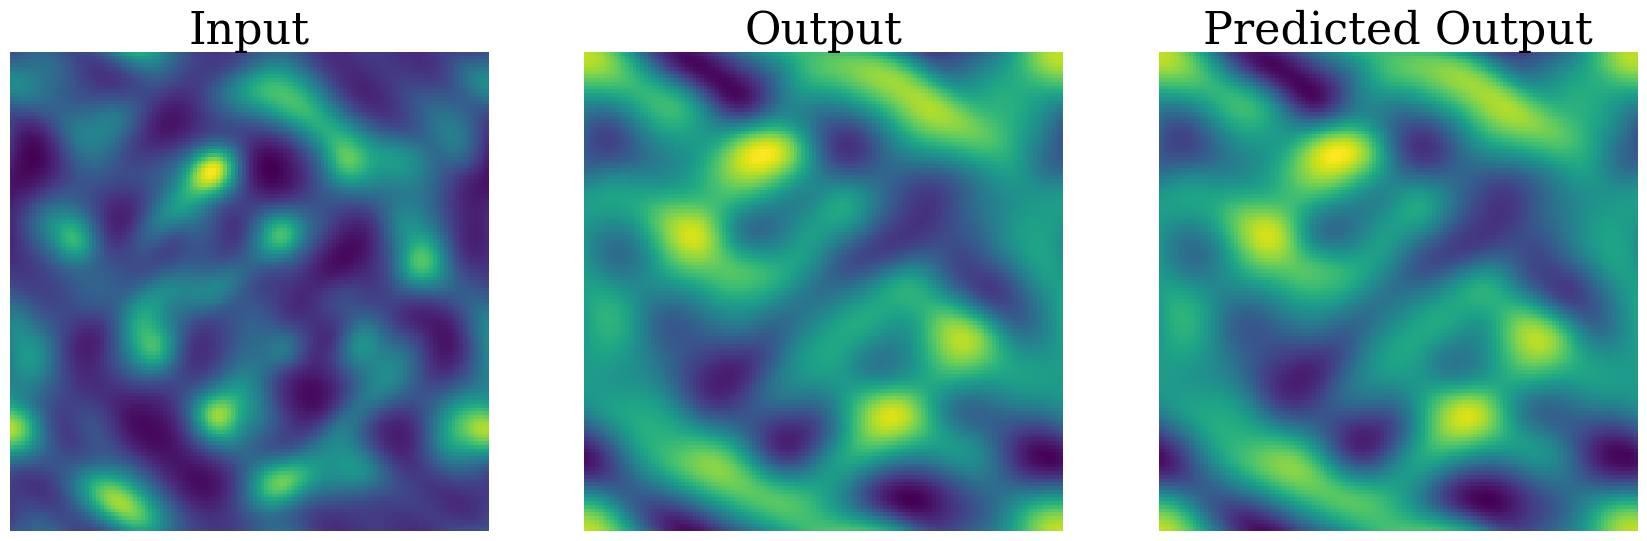

In [19]:

input_sample, output_sample, pred = eval_model(model_name, 'xy', index_count = 5)

# Compute prediction error
loss = Sobolev_Loss(d = 2, p = 2)
err = loss.Lp_rel_err(pred, output_sample)
print("Mean Relative Error: ", torch.mean(err).item())

# to numpy
input_sample = input_sample.detach().numpy()
output_sample = output_sample.detach().numpy()
pred = pred.detach().numpy()
# plot all three
fig, ax = plt.subplots(1,3, figsize=(21,7))
ax[0].imshow(input_sample[0,0], cmap='viridis')
ax[0].set_title('Input', fontsize=fontsize)
ax[0].axis('off')
ax[1].imshow(output_sample[0,0], cmap='viridis')
ax[1].set_title('Output', fontsize=fontsize)
ax[1].axis('off')
ax[2].imshow(pred[0,0], cmap='viridis')
ax[2].set_title('Predicted Output', fontsize=fontsize)
ax[2].axis('off')
plt.savefig('../Figures/Periodic_Example.pdf')

plt.show()


#### Compute error values for inputs of different smoothness s of the standard model

In [63]:
all_err_s_xy = []
true_norms_s_xy = []

for s in s_vals:
    err, norms = get_err_norms(s,sizes = sizes, model_name = model_name)
    all_err_s_xy.append(err)
    true_norms_s_xy.append(norms)

true_norms_s_xy = np.array(true_norms_s_xy)
n_layers = true_norms_s_xy.shape[1]
plot_sizes = sizes[:-1]


False
cpu
False
cpu
False
cpu
False
cpu


#### Plot the norms of the layers for the highest discretization (Smooth data x-y grid model)

3
s =  0.5  slope =  0.23483085632324036  2^slope =  1.176768763039792
s =  1.0  slope =  0.08586359024047527  2^slope =  1.0613228539643154
s =  1.5  slope =  0.1995496749877896  2^slope =  1.1483398545093964
s =  2.0  slope =  -0.04237985610962142  2^slope =  0.9710517876423117


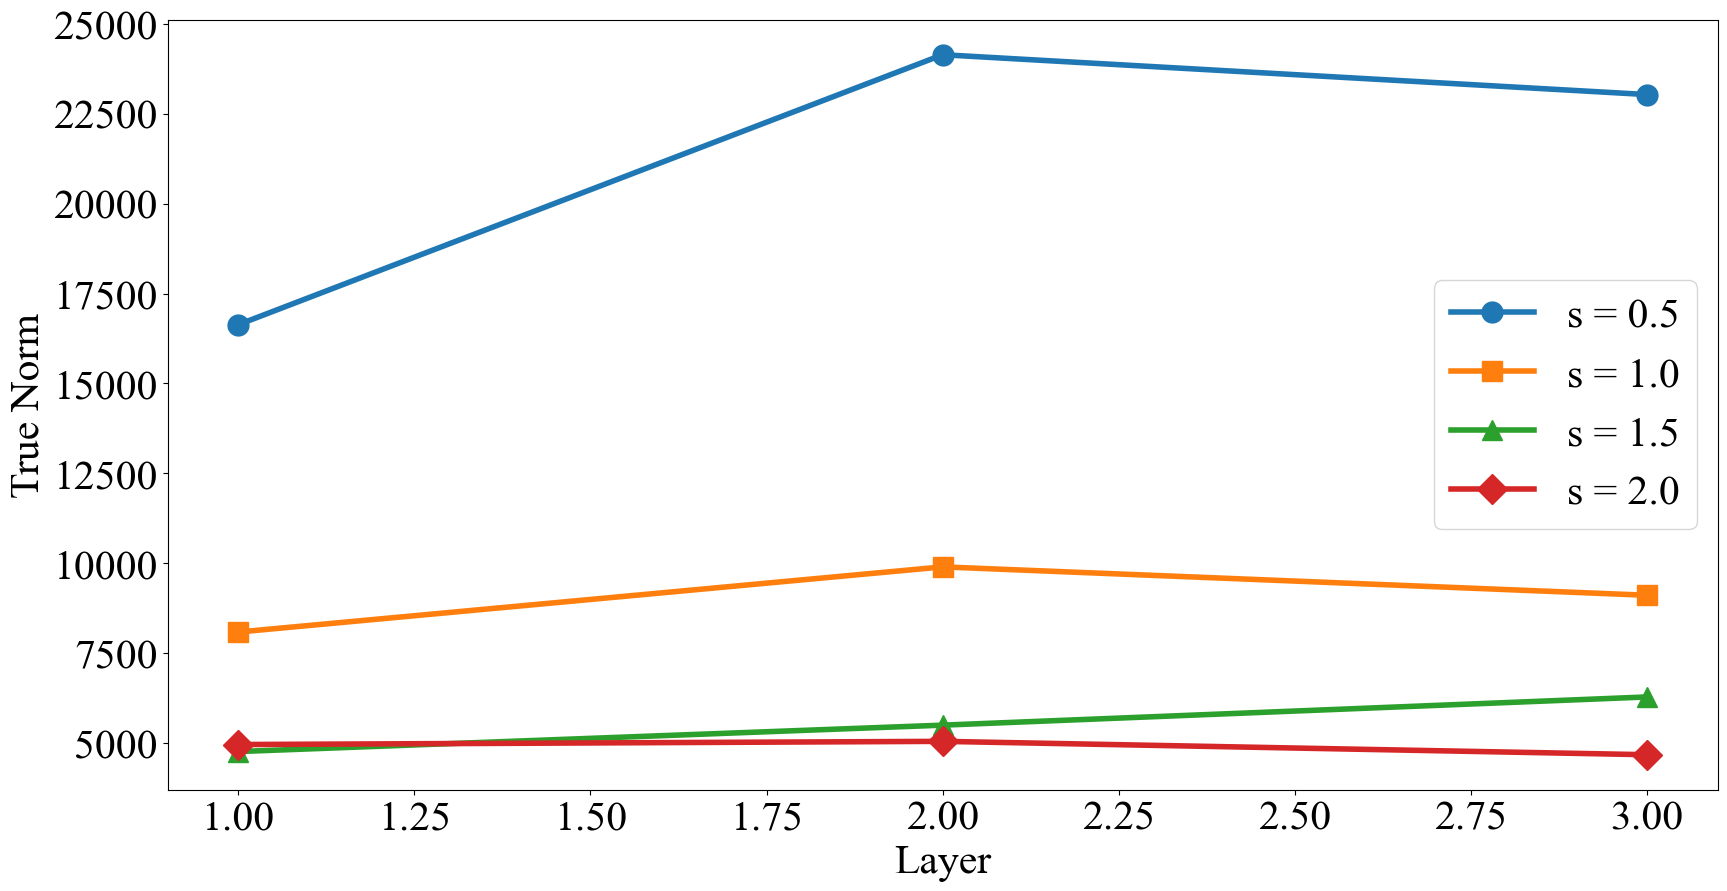

In [82]:
# Plot True Norms s 
fig, ax = plt.subplots(1, 1, figsize=(20,10))
layers = np.linspace(1, n_layers, n_layers)
print(len(layers))
for i, s in enumerate(s_vals):
    ax.plot(layers, true_norms_s_xy[i,:,0], label = 's = ' + str(s), marker = shapes[i], markersize = markersize, linewidth = linewidth)
ax.legend()
# ax.set_yscale('log')

ax.set_xlabel('Layer')
ax.set_ylabel('True Norm')

# get slope
slopes = []
for i, s in enumerate(s_vals):
    x = layers
    y = np.log2(true_norms_s_xy[i,:,0])
    slope = np.polyfit(x, y, 1)[0]
    slopes.append(slope)
    print('s = ', s, ' slope = ', slope, ' 2^slope = ', 2**slope)


In [83]:
# Normalize all_err_s by true_norms_s
all_err_s_xy = np.array(all_err_s_xy)
n_samples = all_err_s_xy.shape[-1]
all_err_s_norm_xy = np.zeros((len(s_vals),len(plot_sizes),n_layers,n_samples))
for i in range(len(s_vals)):
    for j in range(n_layers):
        all_err_s_norm_xy[i,:,j,:] = all_err_s_xy[i,:,j,:] / true_norms_s_xy[i,j,0]

#### Plot the results of different s inputs for random model 

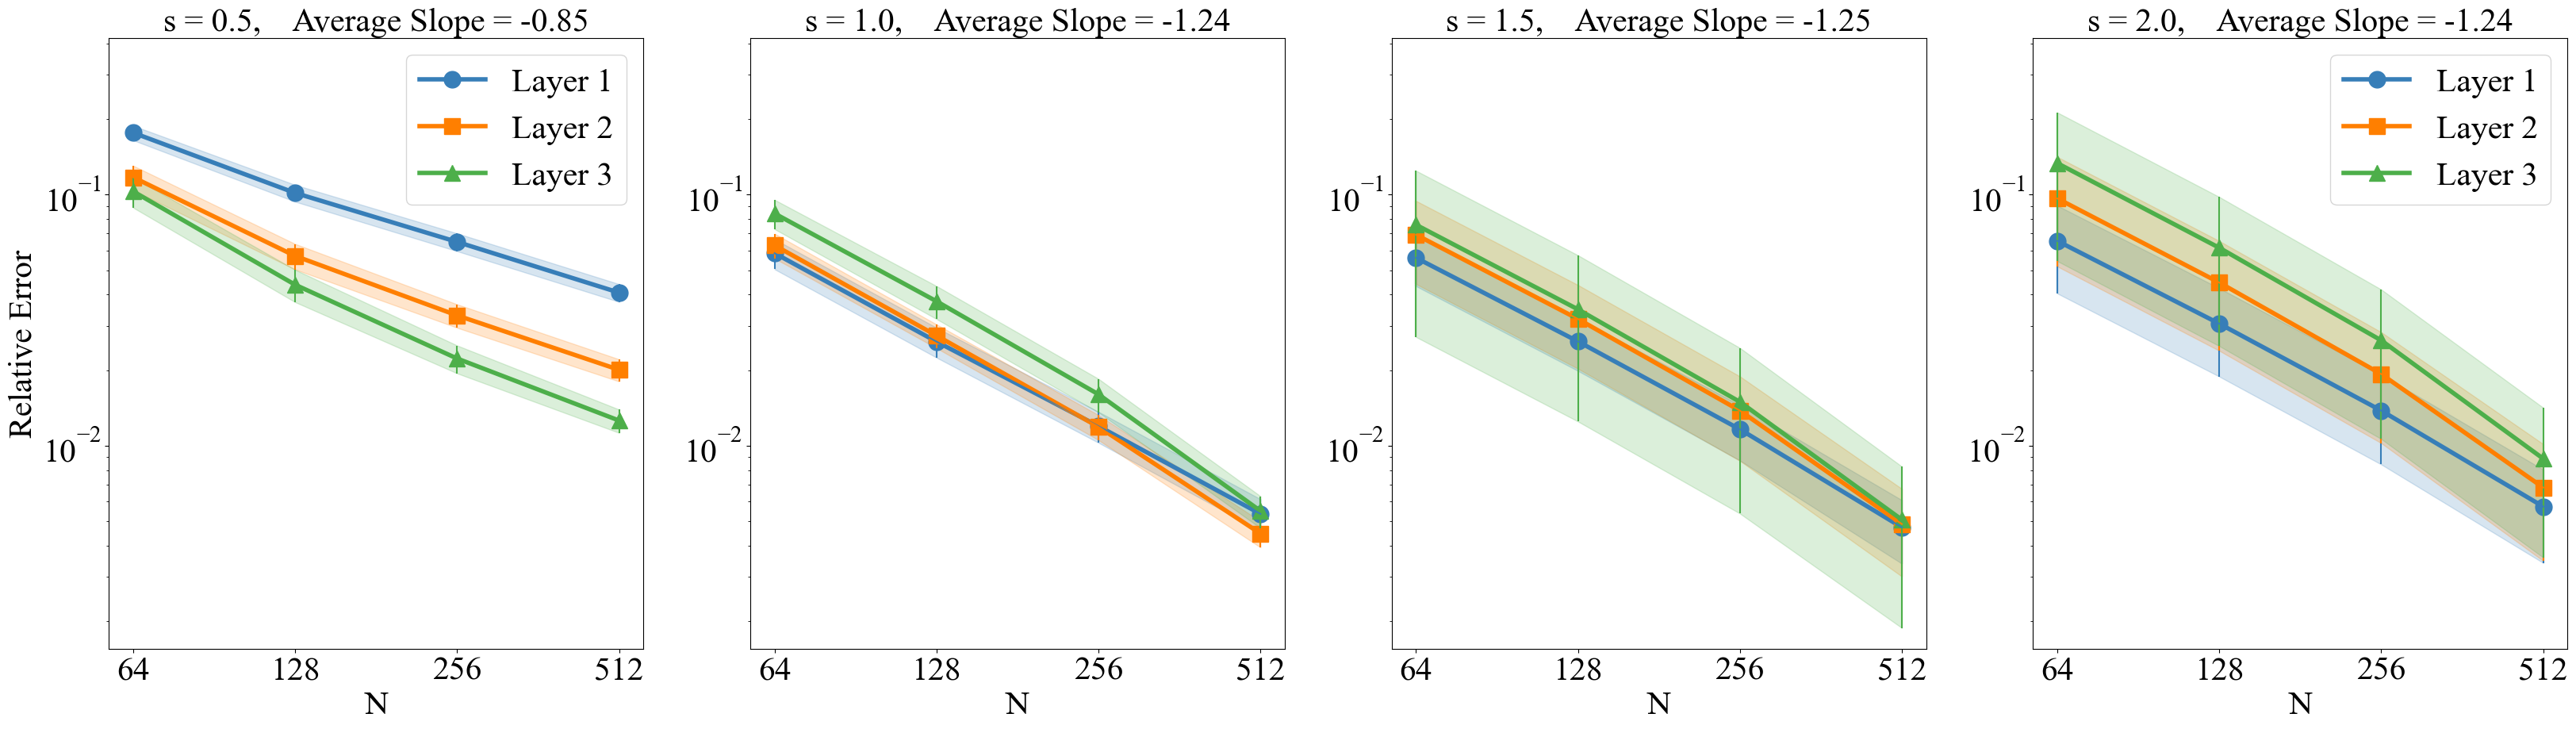

In [84]:
# Error versus N for different s
sizes_plot = sizes[:-1]
fix, ax = plt.subplots(1,4, figsize=(40, 10))

for i, s in enumerate(s_vals):
    all_err = all_err_s_norm_xy[i]

    all_err_mean = np.mean(all_err, axis = -1)
    all_err_std = 2*np.std(all_err, axis = -1)

    slopes = []

    for layer in range(all_err.shape[1]):
        ax[i].plot(sizes_plot,all_err_mean[:,layer],label = f'Layer {layer+1}',color = CB_color_cycle[layer],marker = shapes[layer],linewidth = linewidth,markersize = markersize)
        ax[i].errorbar(sizes_plot, all_err_mean[:,layer], yerr=all_err_std[:,layer],color = CB_color_cycle[layer])
        ax[i].fill_between(sizes_plot, all_err_mean[:,layer] - all_err_std[:,layer], all_err_mean[:,layer] + all_err_std[:,layer], alpha=0.2, color = CB_color_cycle[layer])

        p = np.polyfit(np.log(sizes_plot), np.log(all_err_mean[:,layer]), 1)
        slopes.append(p[0])

    ax[i].set_title('s = ' + str(s) + f',    Average Slope = {np.mean(slopes):.2f}') 
    # logscale
    ax[i].set_yscale('log')
    # set y range
    ax[i].set_ylim([np.min(all_err_s_norm_xy)/2, np.max(all_err_s_norm_xy)*2])
    ax[i].set_xscale('log') 
    ax[i].set_xlabel('N')
    ax[i].set_xticks([])
    ax[i].xaxis.set_minor_locator(plt.NullLocator())

    # no scientific notation x labels

    ax[i].set_xticks(sizes_plot, sizes_plot)
ax[0].set_ylabel('Relative Error') 
# put legend on right of all subplots
ax[0].legend()
ax[3].legend()
# save figure
plt.savefig('../Figures/Err_vs_N_smooth_xy.pdf')



## Smooth Data Periodic Grid Model

In [98]:
# Load config file
config_name = 'smooth_periodic_grid'
model_name = config_name
# print CUDA available
print(torch.cuda.is_available())
config_path = '../models/trained_models/' + config_name + '_info.yaml'
with open(config_path, 'r') as file:
    config = yaml.load(file, Loader=yaml.FullLoader)

# Load input and output data
input_data = torch.load('../data/smooth_training_data/A_to_chi1_tiny_input_data.pt')
output_data = torch.load('../data/smooth_training_data/A_to_chi1_tiny_output_data.pt')

model_name = config['model_name']

False


### Plot predicted versus true for the Periodic grid smooth data model

True
cpu
Mean Relative Error:  0.009467171505093575


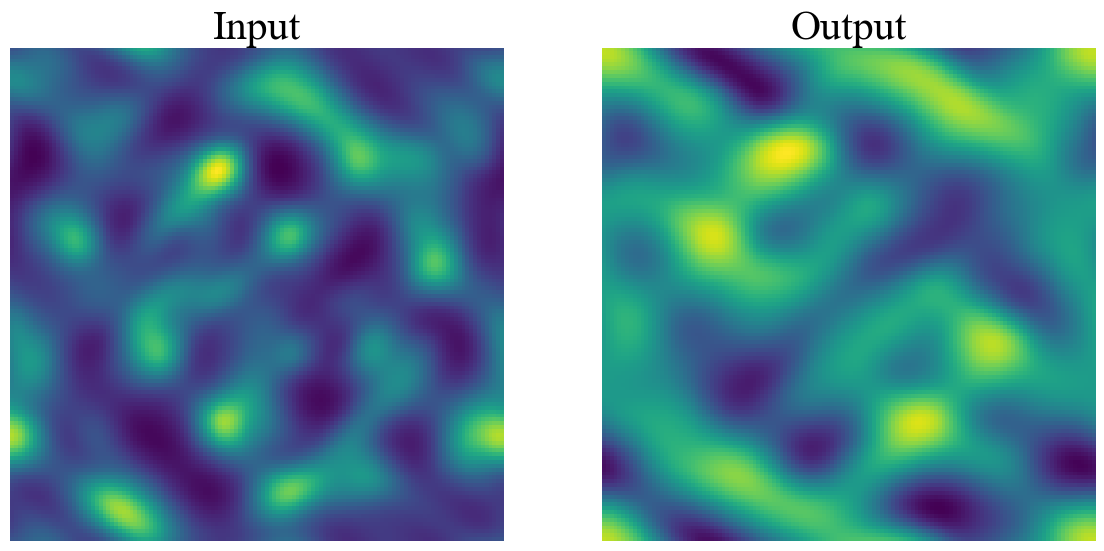

In [99]:

input_sample, output_sample, pred = eval_model(model_name, 'periodic', index_count = 5)

# Compute prediction error
loss = Sobolev_Loss(d = 2, p = 2)
err = loss.Lp_rel_err(pred, output_sample)
print("Mean Relative Error: ", torch.mean(err).item())

# to numpy
input_sample = input_sample.detach().numpy()
output_sample = output_sample.detach().numpy()
pred = pred.detach().numpy()
# plot all three
fig, ax = plt.subplots(1,2, figsize=(14,7))
ax[0].imshow(input_sample[0,0], cmap='viridis')
ax[0].set_title('Input', fontsize = fontsize)
ax[0].axis('off')
ax[1].imshow(output_sample[0,0], cmap='viridis')
ax[1].set_title('Output', fontsize = fontsize)
ax[1].axis('off')
# ax[2].imshow(pred[0,0], cmap='viridis')
# ax[2].set_title('Predicted Output', fontsize = fontsize)
# ax[2].axis('off')

plt.savefig('../Figures/Periodic_Example.pdf')
plt.show()




In [69]:
all_err_s_per = []
true_norms_s_per = []

for s in s_vals:
    err, norms = get_err_norms(s,sizes = sizes, model_name = model_name)
    all_err_s_per.append(err)
    true_norms_s_per.append(norms)

true_norms_s_per = np.array(true_norms_s_per)
n_layers = true_norms_s_per.shape[1]
plot_sizes = sizes[:-1]


True
cpu
True
cpu
True
cpu
True
cpu


3
s =  0.5  slope =  -0.09019660949707242  2^slope =  0.9393947204180073
s =  1.0  slope =  -0.22503328323364316  2^slope =  0.8555752871794157
s =  1.5  slope =  0.0010843276977529487  2^slope =  1.0007518812075697
s =  2.0  slope =  -0.2502827644348175  2^slope =  0.8407316179176962


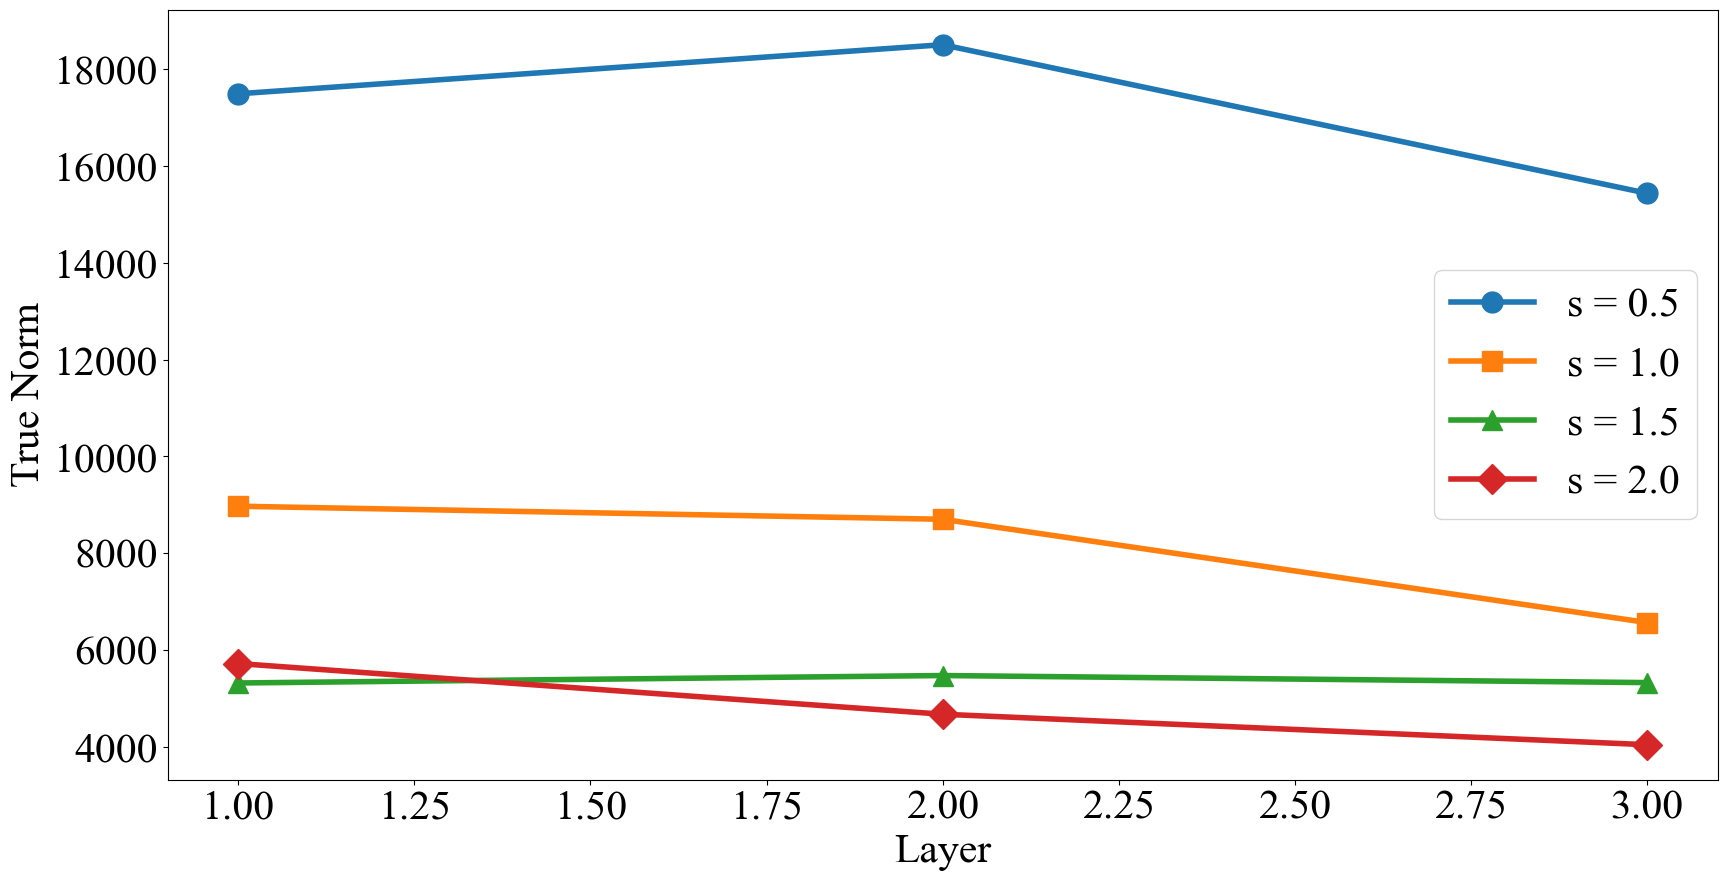

In [70]:
# Plot True Norms s 
fig, ax = plt.subplots(1, 1, figsize=(20,10))
layers = np.linspace(1, n_layers, n_layers)
print(len(layers))
for i, s in enumerate(s_vals):
    ax.plot(layers, true_norms_s_per[i,:,0], label = 's = ' + str(s), marker = shapes[i], markersize = markersize, linewidth = linewidth)
ax.legend()
# ax.set_yscale('log')

ax.set_xlabel('Layer')
ax.set_ylabel('True Norm')

# get slope
slopes = []
for i, s in enumerate(s_vals):
    x = layers
    y = np.log2(true_norms_s_per[i,:,0])
    slope = np.polyfit(x, y, 1)[0]
    slopes.append(slope)
    print('s = ', s, ' slope = ', slope, ' 2^slope = ', 2**slope)


In [71]:
# Normalize all_err_s by true_norms_s
all_err_s_per = np.array(all_err_s_per)
n_samples = all_err_s_per.shape[-1]
all_err_s_norm_per = np.zeros((len(s_vals),len(plot_sizes),n_layers,n_samples))
for i in range(len(s_vals)):
    for j in range(n_layers):
        all_err_s_norm_per[i,:,j,:] = all_err_s_per[i,:,j,:] / true_norms_s_per[i,j,0]

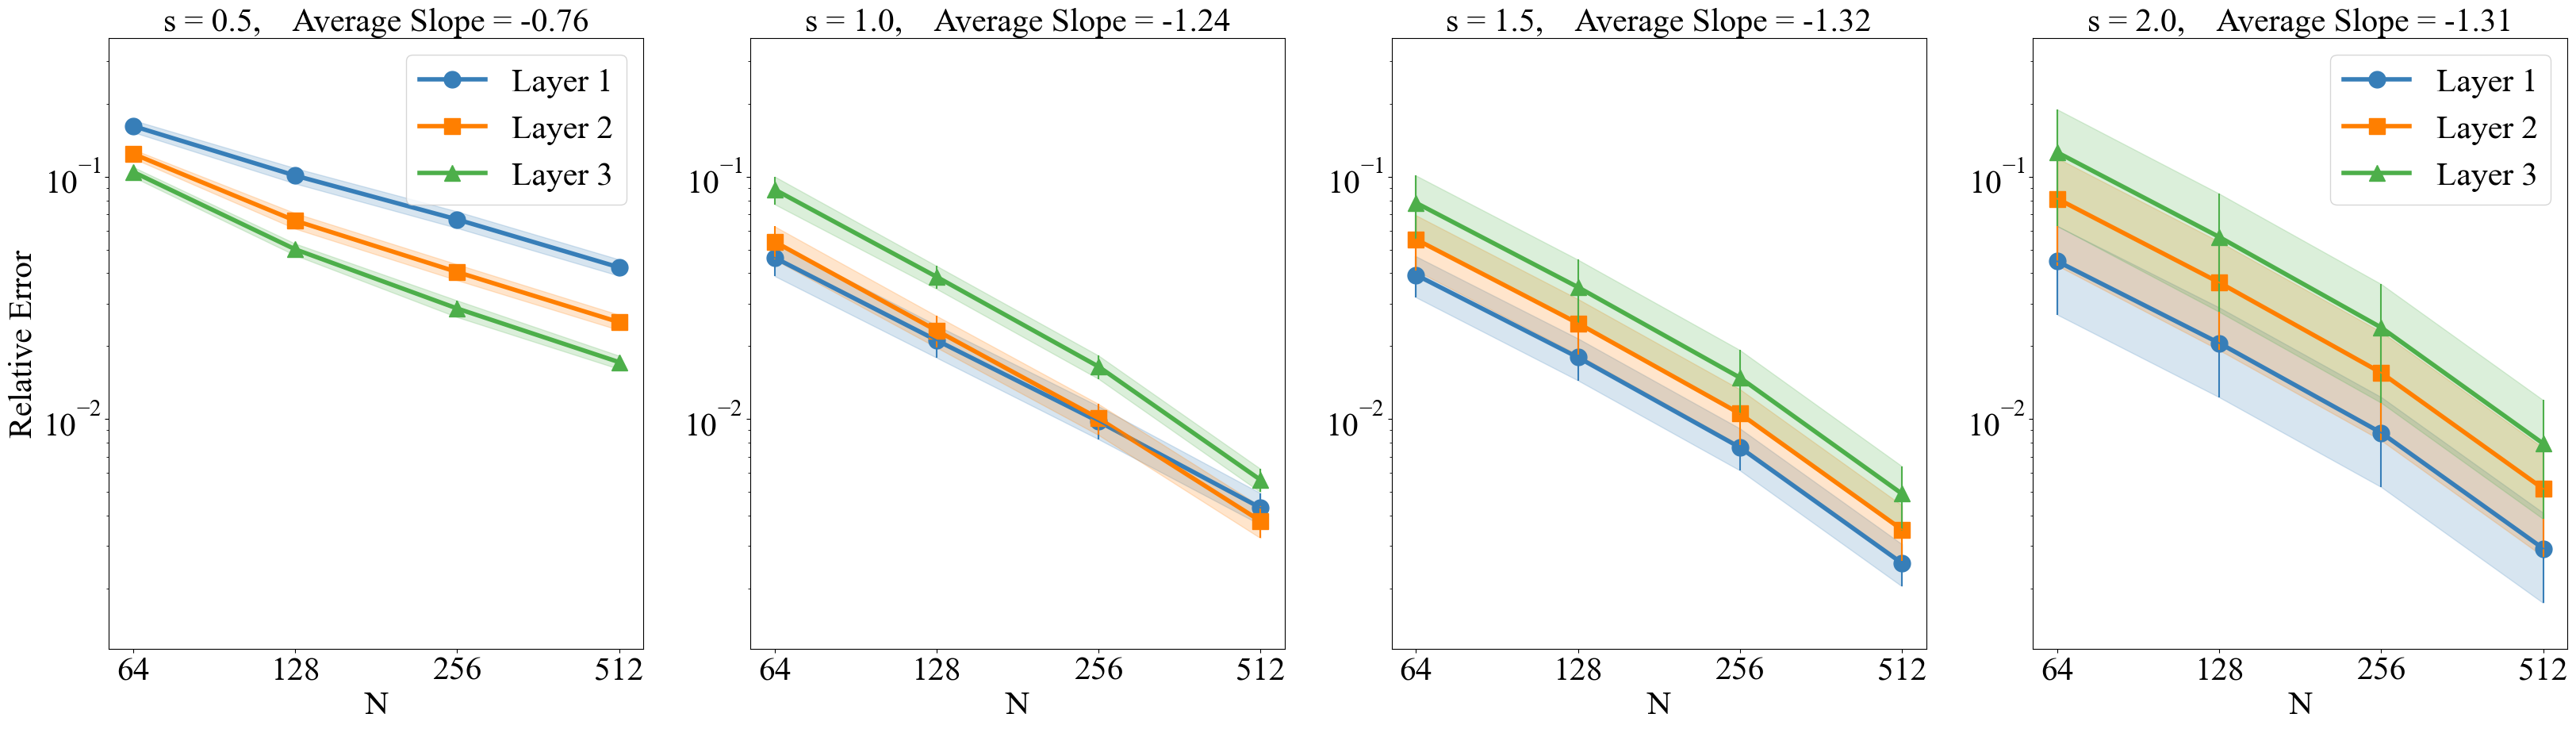

In [72]:
# Error versus N for different s
sizes_plot = sizes[:-1]
fix, ax = plt.subplots(1,4, figsize=(40, 10))

for i, s in enumerate(s_vals):
    all_err = all_err_s_norm_per[i]

    all_err_mean = np.mean(all_err, axis = -1)
    all_err_std = 2*np.std(all_err, axis = -1)

    slopes = []

    for layer in range(all_err.shape[1]):
        ax[i].plot(sizes_plot,all_err_mean[:,layer],label = f'Layer {layer+1}',color = CB_color_cycle[layer],marker = shapes[layer],linewidth = linewidth,markersize = markersize)
        ax[i].errorbar(sizes_plot, all_err_mean[:,layer], yerr=all_err_std[:,layer],color = CB_color_cycle[layer])
        ax[i].fill_between(sizes_plot, all_err_mean[:,layer] - all_err_std[:,layer], all_err_mean[:,layer] + all_err_std[:,layer], alpha=0.2, color = CB_color_cycle[layer])

        p = np.polyfit(np.log(sizes_plot), np.log(all_err_mean[:,layer]), 1)
        slopes.append(p[0])

    ax[i].set_title('s = ' + str(s) + f',    Average Slope = {np.mean(slopes):.2f}') 
    # logscale
    ax[i].set_yscale('log')
    # set y range
    ax[i].set_ylim([np.min(all_err_s_norm_per)/2, np.max(all_err_s_norm_per)*2])
    ax[i].set_xscale('log') 
    ax[i].set_xlabel('N')
    ax[i].set_xticks([])
    ax[i].xaxis.set_minor_locator(plt.NullLocator())

    # no scientific notation x labels

    ax[i].set_xticks(sizes_plot, sizes_plot)
ax[0].set_ylabel('Relative Error') 
# put legend on right of all subplots
ax[0].legend()
ax[3].legend()
# save figure
plt.savefig('../Figures/Err_vs_N_smooth_per.pdf')



## Analysis for Grad Model

In [12]:
# Load config file
config_name = 'grad_x_y_grid'
model_name = config_name
# print CUDA available
print(torch.cuda.is_available())
config_path = '../models/trained_models/' + config_name + '_info.yaml'
with open(config_path, 'r') as file:
    config = yaml.load(file, Loader=yaml.FullLoader)

# Load input and output data
input_data = torch.load('../data/grad_training_data/input_data_grad_tiny.pt')
output_data = torch.load('../data/grad_training_data/output_data_grad_tiny.pt')

model_name = config['model_name']

False


Mean Relative Error:  0.11151740700006485


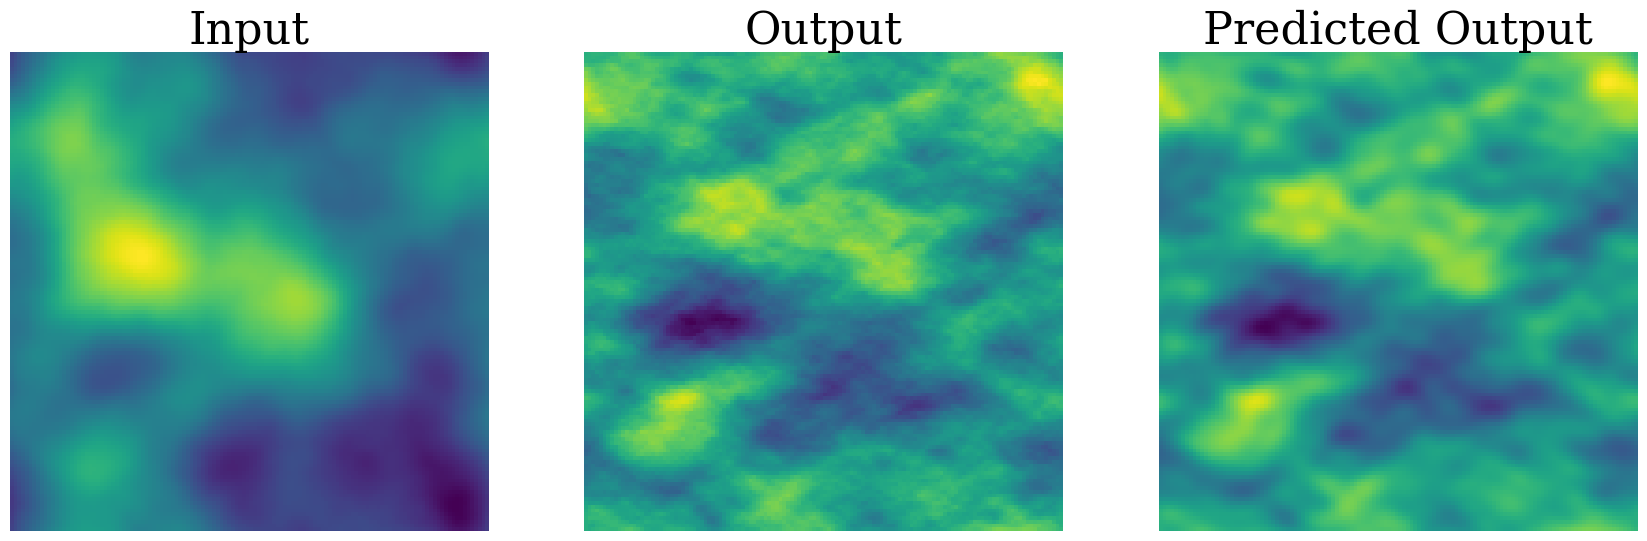

In [13]:

input_sample, output_sample, pred = eval_model(model_name, 'grad', index_count = 5)

# Compute prediction error
loss = Sobolev_Loss(d = 2, p = 2)
err = loss.Lp_rel_err(pred, output_sample)
print("Mean Relative Error: ", torch.mean(err).item())

# to numpy
input_sample = input_sample.detach().numpy()
output_sample = output_sample.detach().numpy()
pred = pred.detach().numpy()
# plot all three
fig, ax = plt.subplots(1,3, figsize=(21,7))
ax[0].imshow(input_sample[0,0], cmap='viridis')
ax[0].set_title('Input')
ax[0].axis('off')
ax[1].imshow(output_sample[0,0], cmap='viridis')
ax[1].set_title('Output')
ax[1].axis('off')
ax[2].imshow(pred[0,0], cmap='viridis')
ax[2].set_title('Predicted Output')
ax[2].axis('off')

plt.savefig('../Figures/Grad_Example.pdf')
plt.show()

In [75]:
all_err_s_grad = []
true_norms_s_grad = []

for s in s_vals:
    err, norms = get_err_norms(s,sizes = sizes, model_name = model_name, dup_input = False)
    all_err_s_grad.append(err)
    true_norms_s_grad.append(norms)

true_norms_s_grad = np.array(true_norms_s_grad)
print(true_norms_s_grad.shape)
print(all_err_s_xy[0].shape)
n_layers = true_norms_s_grad.shape[1]
plot_sizes = sizes[:-1]


True
cpu
True
cpu
True
cpu
True
cpu
(4, 3, 5)
(4, 3, 5)


3
s =  0.5  slope =  0.8807830810546845  2^slope =  1.8413745104981254
s =  1.0  slope =  0.5287876129150376  2^slope =  1.4427162810154561
s =  1.5  slope =  0.23478460311889418  2^slope =  1.1767310361106613
s =  2.0  slope =  0.17315769195556405  2^slope =  1.1275236479555732


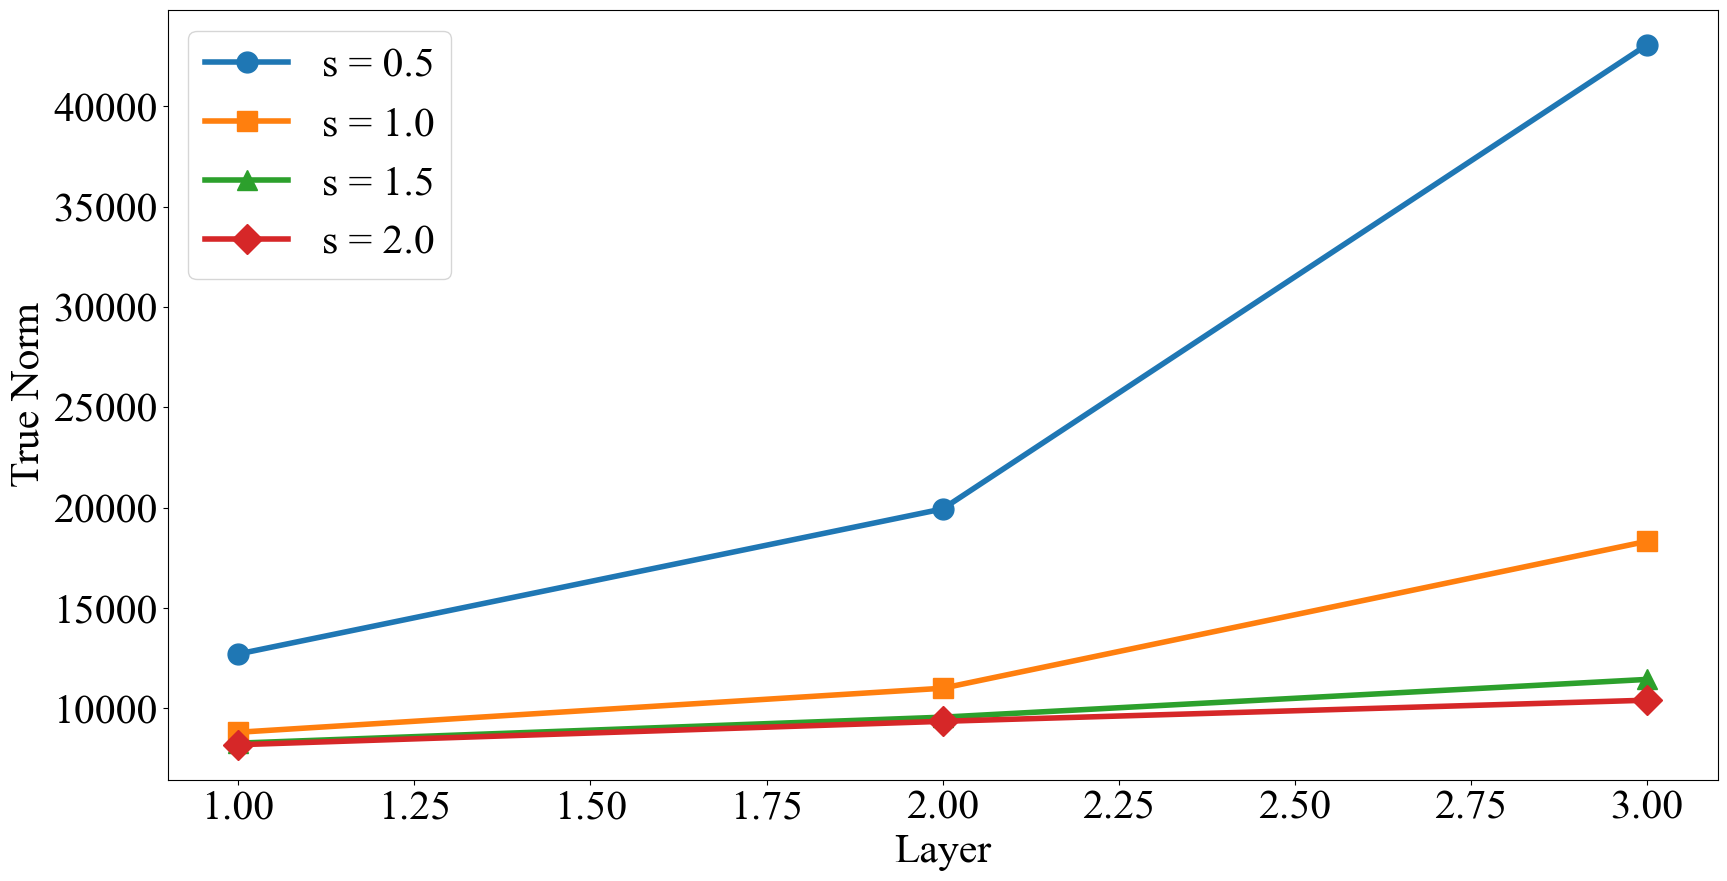

In [85]:
# Plot True Norms s 
fig, ax = plt.subplots(1, 1, figsize=(20,10))
layers = np.linspace(1, n_layers, n_layers)
print(len(layers))
for i, s in enumerate(s_vals):
    ax.plot(layers, true_norms_s_grad[i,:,0], label = 's = ' + str(s), marker = shapes[i], markersize = markersize, linewidth = linewidth)
ax.legend()
# ax.set_yscale('log')

ax.set_xlabel('Layer')
ax.set_ylabel('True Norm')

# get slope
slopes = []
for i, s in enumerate(s_vals):
    x = layers
    y = np.log2(true_norms_s_grad[i,:,0])
    slope = np.polyfit(x, y, 1)[0]
    slopes.append(slope)
    print('s = ', s, ' slope = ', slope, ' 2^slope = ', 2**slope)


In [86]:
# Normalize all_err_s by true_norms_s
all_err_s_grad = np.array(all_err_s_grad)
n_samples = all_err_s_grad.shape[-1]
all_err_s_norm_grad = np.zeros((len(s_vals),len(plot_sizes),n_layers,n_samples))
for i in range(len(s_vals)):
    for j in range(n_layers):
        all_err_s_norm_grad[i,:,j,:] = all_err_s_grad[i,:,j,:] / true_norms_s_grad[i,j,0]

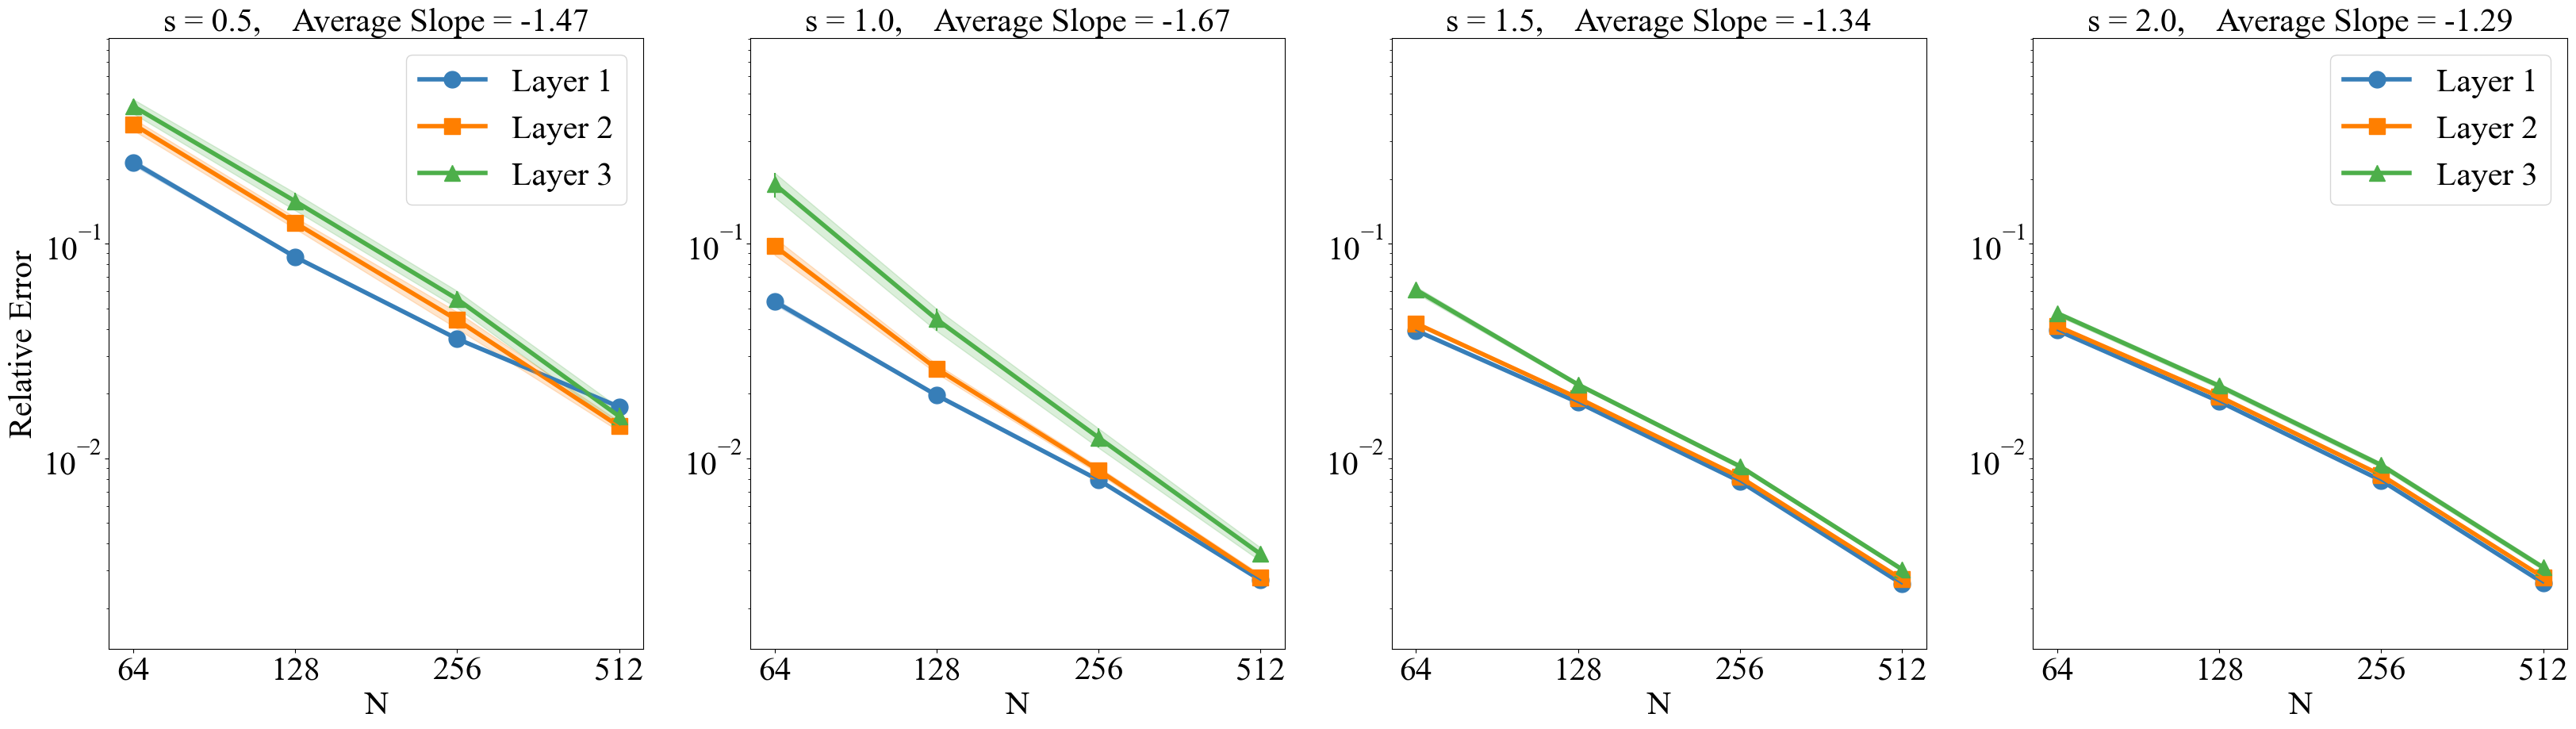

In [87]:
# Error versus N for different s
sizes_plot = sizes[:-1]
fix, ax = plt.subplots(1,4, figsize=(40, 10))

for i, s in enumerate(s_vals):
    all_err = all_err_s_norm_grad[i]

    all_err_mean = np.mean(all_err, axis = -1)
    all_err_std = 2*np.std(all_err, axis = -1)

    slopes = []

    for layer in range(all_err.shape[1]):
        ax[i].plot(sizes_plot,all_err_mean[:,layer],label = f'Layer {layer+1}',color = CB_color_cycle[layer],marker = shapes[layer],linewidth = linewidth,markersize = markersize)
        ax[i].errorbar(sizes_plot, all_err_mean[:,layer], yerr=all_err_std[:,layer],color = CB_color_cycle[layer])
        ax[i].fill_between(sizes_plot, all_err_mean[:,layer] - all_err_std[:,layer], all_err_mean[:,layer] + all_err_std[:,layer], alpha=0.2, color = CB_color_cycle[layer])

        p = np.polyfit(np.log(sizes_plot), np.log(all_err_mean[:,layer]), 1)
        slopes.append(p[0])

    ax[i].set_title('s = ' + str(s) + f',    Average Slope = {np.mean(slopes):.2f}') 
    # logscale
    ax[i].set_yscale('log')
    # set y range
    ax[i].set_ylim([np.min(all_err_s_norm_grad)/2, np.max(all_err_s_norm_grad)*2])
    ax[i].set_xscale('log') 
    ax[i].set_xlabel('N')
    ax[i].set_xticks([])
    ax[i].xaxis.set_minor_locator(plt.NullLocator())

    # no scientific notation x labels

    ax[i].set_xticks(sizes_plot, sizes_plot)
ax[0].set_ylabel('Relative Error') 
# put legend on right of all subplots
ax[0].legend()
ax[3].legend()
# save figure
plt.savefig('../Figures/Err_vs_N_smooth_grad.pdf')

